In [1]:
import pandas as pd
import numpy as np
import requests
import pickle as pkl
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cross_validation import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix

from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE, ADASYN

from collections import Counter

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

%matplotlib inline

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
plt.style.use("seaborn")

/home/pnietoramos/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


### Defining Features and Classifier

In [2]:
df_multi = pd.read_csv("Fire_multi.csv", index_col=False)

In [3]:
df_multi.head(1)

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Cover_Type,Soil_Type
0,2596,51,3,258,0,510,221,232,148,0,5,29


In [4]:
X = df_multi.drop("Horizontal_Distance_To_Fire_Points",axis=1)
y = df_multi["Horizontal_Distance_To_Fire_Points"]

In [5]:
#Splitting the set (test = 0.3) in a stratified manner
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.30,stratify=y, random_state=4444)

In [6]:
#scaling the features
sca = StandardScaler()
sca.fit_transform(X_train)
sca.transform(X_test);

### Oversampling with SMOTE

In [231]:
col_in = ["Elevation","Horizontal_Distance_To_Roadways", "Soil_Type",
          "Horizontal_Distance_To_Hydrology","Vertical_Distance_To_Hydrology"]
X_in = X[col_in]
X_train_in = X_train[col_in]
X_test_in = X_test[col_in]

In [232]:
X_smoted, y_smoted = SMOTE(random_state=42).fit_sample(X_train_in,y_train)

In [233]:
rf = RandomForestClassifier(max_leaf_nodes=5000000, max_depth=50, n_estimators=200)
rf.fit(X_smoted, y_smoted)
y_pred = rf.predict(X_test_in)
y_pred_train = rf.predict(X_smoted)
print(accuracy_score(y_pred_train, y_smoted))
print(accuracy_score(y_pred, y_test))


0.9999704948021676
0.9308736460436938


In [10]:
print("Recall for cover:")
for i in range(3):
    print("Type " + str(i)+ ":" + str(100 * confusion_matrix(y_test, y_pred)[i,i]/len(y_test[y_test==(i)])))

Recall for cover:
Type 0:95.29717648132099
Type 1:91.29885408043222
Type 2:89.07033053662931


In [11]:
print("Precision for cover:")
for i in range(3):
    print("Type " + str(i)+ ":" + str(100 * confusion_matrix(y_test, y_pred)[i,i]/len(y_pred[y_pred==(i)])))

Precision for cover:
Type 0:95.10304878742703
Type 1:93.01176296515499
Type 2:83.92402376910017


### Training with the whole set with oversampling

In [234]:
col_in = ["Elevation","Horizontal_Distance_To_Roadways", "Soil_Type","Horizontal_Distance_To_Hydrology","Vertical_Distance_To_Hydrology"]
X_in = X[col_in]
X_train_in = X_train[col_in]
X_test_in = X_test[col_in]


In [235]:
X_SMOTE_all, y_SMOTE_all = SMOTE(random_state=42).fit_sample(X_in,y)

In [236]:
rf = RandomForestClassifier(max_leaf_nodes=5000000, max_depth=50, n_estimators=200)
rf.fit(X_SMOTE_all, y_SMOTE_all)
y_pred = rf.predict(X_in)
print(accuracy_score(y_pred, y))

0.9999500870894232


In [237]:
print("Recall for cover:")
for i in range(3):
    print("Type " + str(i)+ ":" + str(100 * confusion_matrix(y, y_pred)[i,i]/len(y[y==(i)])))

Recall for cover:
Type 0:99.99760525748614
Type 1:99.99302859582849
Type 2:99.98986418001216


In [238]:
print("Precision for cover:")
for i in range(3):
    print("Type " + str(i)+ ":" + str(100 * confusion_matrix(y, y_pred)[i,i]/len(y_pred[y_pred==(i)])))

Precision for cover:
Type 0:99.99657897437652
Type 1:99.99607846554714
Type 2:99.98310810810811


### Predictions and visualizations

["Elevation","Horizontal_Distance_To_Roadways", "Soil_Type","Horizontal_Distance_To_Hydrology","Vertical_Distance_To_Hydrology"]

In [24]:
sca_all = StandardScaler()
sca_all.fit_transform(X_in);

In [221]:
#One random example
example = np.array([2500, 750, 11, 800, 50])
sca_all.transform(example.reshape(1,-1))
rf.predict(example.reshape(1,-1))


/home/pnietoramos/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


array([2])

In [247]:
example_2d = []
for item_1 in range(0, 7000,10):
    for item_2 in range(0, 1000,2):
        example_2d.append([2500, item_1, 11, item_2, 50])

In [248]:
sca_all.transform(example_2d)
fire = rf.predict(example_2d)

In [249]:
#Consider only high risk zones
fire = [int(item==2) for item in fire]

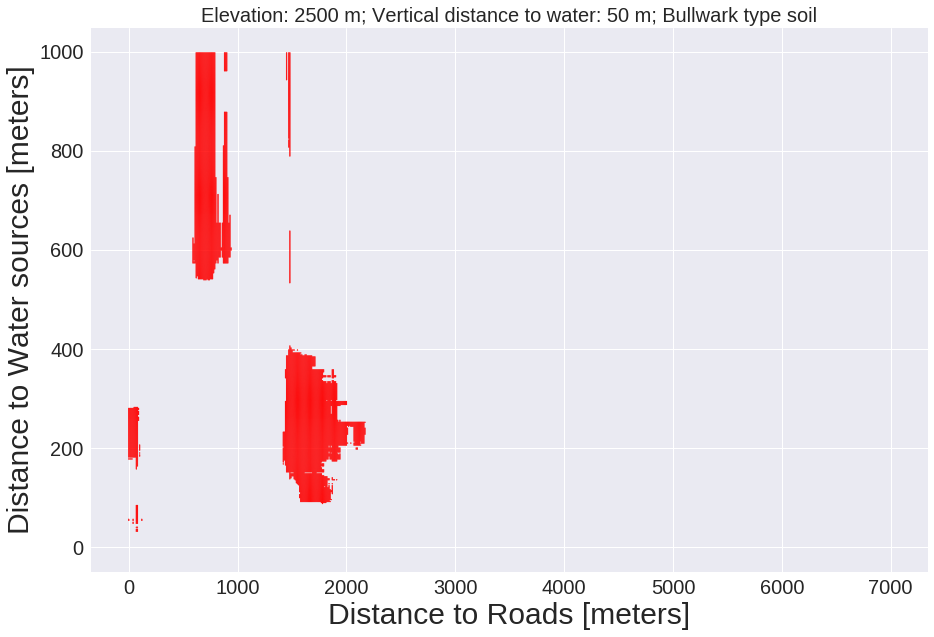

In [255]:
plt.figure(figsize=(15,10))
plt.scatter([item[1] for item in example_2d], [item[3] for item in example_2d], fire, c= "r")
plt.tick_params(labelsize=20)
plt.title("Elevation: 2500 m; Vertical distance to water: 50 m; Bullwark type soil", fontsize = 20)
plt.xlabel("Distance to Roads [meters]", fontsize = 30)
plt.ylabel("Distance to Water sources [meters]", fontsize = 30);
plt.savefig("Prediction_fire", dpi=200)
